You are required to use the MNIST dataset for this question. Implement the Models using
PyTorch. For the accuracy part you can use Structural Similarity (SSIM) from scikit-learn to
compare 2 images.
Tasks
1. Implement the Encoder - Decoders Models
2. Add Gaussian Noise to the images and train the model. Use various values of sigma (3
different values) in the Gaussian and plot the average SSIM test score for these 3 varying sigma
values. Explain your observations.
3. Now keep the Sigma constant and change the bottleneck dimensionality (3 different values)
of the Model and plot the average SSIM test score for these 3 values. Explain your
observations.


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
from skimage.metrics import structural_similarity as ssim


In [29]:
# importing mnist dataset
train_data = MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [32]:
class Autoencoder(nn.Module):
    def __init__(self, bottleneck):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # input channels = 1, output channels = 16, kernel size = 3x3
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  
            nn.ReLU(True),  # ReLU activation function
            # input channels = 16, output channels = 32, kernel size = 3x3
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  
            nn.ReLU(True),  
            # input channels = 32, output channels = bottleneck, kernel size = 7x7
            nn.Conv2d(32, bottleneck, 7) 
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            # nput channels = bottleneck, output channels = 32, kernel size = 7x7
            nn.ConvTranspose2d(bottleneck, 32, 7),  
            nn.ReLU(True),  # ReLU activation function
            # input channels = 32, output channels = 16, kernel size = 3x3
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(True), 
            # input channels = 16, output channels = 1, kernel size = 3x3
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()  # Sigmoid activation function
        )
        
        self.bottleneck = bottleneck  

    def forward(self, x):
        x = self.encoder(x) 
        x = self.decoder(x)
        return x  


In [33]:
# adding gaussian noise to the input
def add_noise(img, sigma):
    img = img + sigma * torch.randn(img.size())
    # ensuring pixel sizes are between 0 and 1
    noisyImg = torch.clamp(img, 0., 1.)
    return noisyImg

In [34]:
# making the dataloaders
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)


In [35]:
# training the autoencoder
def train(model, train_loader, sigma, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            # adding noise to the input
            noisy_img = add_noise(img, sigma)
            img = img.to(device)
            noisy_img = noisy_img.to(device)
            
            # Forward pass
            output = model(noisy_img)
            loss = criterion(output, img)

            # backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
            



In [36]:
# testing the autoencoder
def test(model, test_loader, sigma):
    ssim_scores = []
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            noisy_img = add_noise(img, sigma)
            img = img.to(device)
            noisy_img = noisy_img.to(device)
            
            output = model(noisy_img)
            
            for i in range(len(img)):
                ssim_score = ssim(img[i].cpu().numpy().squeeze(), output[i].cpu().numpy().squeeze(), data_range=1.0)
                ssim_scores.append(ssim_score)

    return np.mean(ssim_scores)

In [37]:
sigma_values = [0.3, 0.5, 0.8]
bottleneck_dimensions = [8, 16, 32]
num_epochs = 20

# Lists to store results
avg_ssim_sigma = []
avg_ssim_bottleneck = []
# iterating over all the sigma values with a fixed bottleneck
for sigma in sigma_values:
    model = Autoencoder(bottleneck=8).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train(model, train_loader, sigma, criterion, optimizer, num_epochs)
    avg_ssim = test(model, test_loader, sigma)
    avg_ssim_sigma.append(avg_ssim)
    print(f"Average SSIM for sigma={sigma}: {avg_ssim}")
        


Epoch [1/20], Loss: 0.0289
Epoch [2/20], Loss: 0.0248
Epoch [3/20], Loss: 0.0203
Epoch [4/20], Loss: 0.0228
Epoch [5/20], Loss: 0.0185
Epoch [6/20], Loss: 0.0173
Epoch [7/20], Loss: 0.0201
Epoch [8/20], Loss: 0.0212
Epoch [9/20], Loss: 0.0206
Epoch [10/20], Loss: 0.0234
Epoch [11/20], Loss: 0.0203
Epoch [12/20], Loss: 0.0231
Epoch [13/20], Loss: 0.0185
Epoch [14/20], Loss: 0.0204
Epoch [15/20], Loss: 0.0219
Epoch [16/20], Loss: 0.0196
Epoch [17/20], Loss: 0.0194
Epoch [18/20], Loss: 0.0207
Epoch [19/20], Loss: 0.0190
Epoch [20/20], Loss: 0.0201
Average SSIM for sigma=0.3: 0.7783408050903105
Epoch [1/20], Loss: 0.0343
Epoch [2/20], Loss: 0.0304
Epoch [3/20], Loss: 0.0263
Epoch [4/20], Loss: 0.0279
Epoch [5/20], Loss: 0.0226
Epoch [6/20], Loss: 0.0242
Epoch [7/20], Loss: 0.0218
Epoch [8/20], Loss: 0.0248
Epoch [9/20], Loss: 0.0223
Epoch [10/20], Loss: 0.0255
Epoch [11/20], Loss: 0.0261
Epoch [12/20], Loss: 0.0225
Epoch [13/20], Loss: 0.0232
Epoch [14/20], Loss: 0.0239
Epoch [15/20], Loss

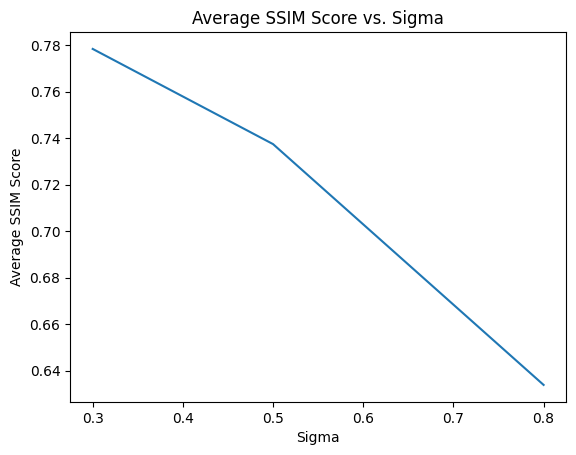

In [44]:
import matplotlib.pyplot as plt

plt.plot(sigma_values, avg_ssim_sigma)
plt.xlabel('Sigma')
plt.ylabel('Average SSIM Score')
plt.title('Average SSIM Score vs. Sigma')
plt.show()


#### Report


- As sigma increases, the average SSIM decreases. This is because higher sigma values correspond to more noise, making it harder for the autoencoder to denoise the images effectively.
- Lower sigma values result in higher SSIM scores, indicating better preservation of structural similarity between the original and denoised images.
- Higher sigma values introduce more distortion to the images, leading to lower SSIM scores.

In [39]:
for bottleneck_dim in bottleneck_dimensions:
    # Define model
    model = Autoencoder(bottleneck_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train model
    train(model, train_loader, 0.5, criterion, optimizer, num_epochs=num_epochs)
    
    # Test model
    avg_ssim = test(model, test_loader, 0.5)
    avg_ssim_bottleneck.append(avg_ssim)
    print("bottleneck = ", bottleneck_dim, "avg ssim = ", avg_ssim)
    


Epoch [1/20], Loss: 0.0324
Epoch [2/20], Loss: 0.0255
Epoch [3/20], Loss: 0.0247
Epoch [4/20], Loss: 0.0238
Epoch [5/20], Loss: 0.0272
Epoch [6/20], Loss: 0.0231
Epoch [7/20], Loss: 0.0217
Epoch [8/20], Loss: 0.0268
Epoch [9/20], Loss: 0.0214
Epoch [10/20], Loss: 0.0243
Epoch [11/20], Loss: 0.0253
Epoch [12/20], Loss: 0.0234
Epoch [13/20], Loss: 0.0217
Epoch [14/20], Loss: 0.0212
Epoch [15/20], Loss: 0.0249
Epoch [16/20], Loss: 0.0226
Epoch [17/20], Loss: 0.0261
Epoch [18/20], Loss: 0.0219
Epoch [19/20], Loss: 0.0198
Epoch [20/20], Loss: 0.0221
bottleneck =  8 avg ssim =  0.7326878460938111
Epoch [1/20], Loss: 0.0251
Epoch [2/20], Loss: 0.0174
Epoch [3/20], Loss: 0.0161
Epoch [4/20], Loss: 0.0155
Epoch [5/20], Loss: 0.0172
Epoch [6/20], Loss: 0.0167
Epoch [7/20], Loss: 0.0162
Epoch [8/20], Loss: 0.0155
Epoch [9/20], Loss: 0.0163
Epoch [10/20], Loss: 0.0152
Epoch [11/20], Loss: 0.0161
Epoch [12/20], Loss: 0.0160
Epoch [13/20], Loss: 0.0159
Epoch [14/20], Loss: 0.0152
Epoch [15/20], Loss

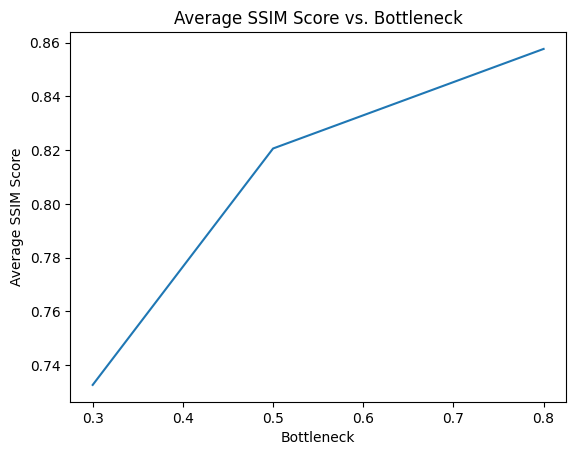

In [45]:
import matplotlib.pyplot as plt

plt.plot(sigma_values, avg_ssim_bottleneck)
plt.xlabel('Bottleneck')
plt.ylabel('Average SSIM Score')
plt.title('Average SSIM Score vs. Bottleneck')
plt.show()


#### Report

- As the bottleneck increases, the model's capacity to capture and reconstruct features increases.
- Higher bottleneck dimensionalities allow for more information preservation during the encoding-decoding process, resulting in higher SSIM scores.
- Lower bottleneck dimensionalities may lead to lossy compression and hence lower SSIM scores as the model struggles to represent the data adequately with limited dimensions.